In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from math import log
from nltk import word_tokenize
import nltk
import math
from collections import Counter
import numpy as np

In [3]:
DIR_PATH = '/Users/marysia/Downloads/archive/DUC2004_Summarization_Documents/duc2004_testdata/tasks1and2'
EXAMPLE_FILE_PATH = '/Users/marysia/Downloads/archive/DUC2004_Summarization_Documents/duc2004_testdata/tasks1and2/duc2004_tasks1and2_docs/docs/1/D1.txt' 

with open(EXAMPLE_FILE_PATH, 'r') as file:
    data = file.read()

data

"\nCambodian leader Hun Sen on Friday rejected opposition parties' demands \nfor talks outside the country, accusing them of trying to ``internationalize'' \nthe political crisis. Government and opposition parties have asked \nKing Norodom Sihanouk to host a summit meeting after a series of post-election \nnegotiations between the two opposition groups and Hun Sen's party \nto form a new government failed. Opposition leaders Prince Norodom \nRanariddh and Sam Rainsy, citing Hun Sen's threats to arrest opposition \nfigures after two alleged attempts on his life, said they could not \nnegotiate freely in Cambodia and called for talks at Sihanouk's residence \nin Beijing. Hun Sen, however, rejected that. ``I would like to make \nit clear that all meetings related to Cambodian affairs must be conducted \nin the Kingdom of Cambodia,'' Hun Sen told reporters after a Cabinet \nmeeting on Friday. ``No-one should internationalize Cambodian affairs. \nIt is detrimental to the sovereignty of Camb

In [4]:
data_list = data.replace('\n','').split('.')
data_list

["Cambodian leader Hun Sen on Friday rejected opposition parties' demands for talks outside the country, accusing them of trying to ``internationalize'' the political crisis",
 " Government and opposition parties have asked King Norodom Sihanouk to host a summit meeting after a series of post-election negotiations between the two opposition groups and Hun Sen's party to form a new government failed",
 " Opposition leaders Prince Norodom Ranariddh and Sam Rainsy, citing Hun Sen's threats to arrest opposition figures after two alleged attempts on his life, said they could not negotiate freely in Cambodia and called for talks at Sihanouk's residence in Beijing",
 ' Hun Sen, however, rejected that',
 " ``I would like to make it clear that all meetings related to Cambodian affairs must be conducted in the Kingdom of Cambodia,'' Hun Sen told reporters after a Cabinet meeting on Friday",
 ' ``No-one should internationalize Cambodian affairs',
 " It is detrimental to the sovereignty of Cambodi

# Create flow

In [126]:
import math

def preprocess_text(sentences):
    """
    Preprocess the sentences by removing stopwords and stemming.
    
    Parameters:
        sentences (list of str): A list of sentences (strings).
        
    Returns:
        list of list: A list of preprocessed terms for each sentence.
    """
    # Load stopwords and initialize stemmer
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    
    preprocessed_sentences = []
    for sentence in sentences:
        terms = [
            stemmer.stem(word) for word in sentence.lower().split()
            if word not in stop_words
        ]
        preprocessed_sentences.append(terms)
    return preprocessed_sentences

def calculate_isf_for_all_terms(sentences):
    """
    Calculate the Inverse Sentence Frequency (ISF) for all terms in a list of sentences.
    
    Parameters:
        sentences (list of str): A list of sentences (strings).
        
    Returns:
        dict: A dictionary where keys are terms and values are their ISF scores.
    """
    # Total number of sentences
    Ns = len(sentences)
    
    # Dictionary to count the number of sentences containing each term
    term_sentence_count = {}
    
    # Process sentences to count terms
    for sentence in sentences:
        # Extract unique terms from the sentence
        terms = set(sentence.split())
        for term in terms:
            if term in term_sentence_count:
                term_sentence_count[term] += 1
            else:
                term_sentence_count[term] = 1
    
    # Calculate ISF for each term
    isf_dict = {}
    for term, Nt_s in term_sentence_count.items():
        isf_dict[term] = math.log(Ns / Nt_s)
    
    return isf_dict

def calculate_tf_isf(sentences, isf_scores):
    """
    Calculate the tf-isf vector for each sentence.
    
    Parameters:
        sentences (list of str): A list of sentences (strings).
        isf_scores (dict): A dictionary of ISF scores for terms.
        
    Returns:
        list of dict: A list of dictionaries representing tf-isf vectors for each sentence.
    """
    tf_isf_vectors = []

    for sentence in sentences:
        term_freq = defaultdict(int)
        terms = sentence.split()  # Split the sentence into words
        
        # Count term frequencies
        for term in terms:
            term_freq[term] += 1
        
        # Calculate tf-isf
        tf_isf = {term: term_freq[term] * isf_scores[term] for term in term_freq if term in isf_scores}
        tf_isf_vectors.append(tf_isf)
    
    return tf_isf_vectors

def calculate_tfisf_matrix(sentences, isf_dict):
    """
    Calculate the TF-ISF matrix for a list of sentences.

    Parameters:
        sentences (list of str): A list of sentences (strings).
        isf_dict (dict): Dictionary of ISF values for terms.

    Returns:
        np.ndarray: TF-ISF matrix (rows: sentences, cols: terms).
        list: List of terms corresponding to the columns of the matrix.
    """
    # Extract all unique terms
    terms = list(isf_dict.keys())
    term_index = {term: idx for idx, term in enumerate(terms)}

    # Initialize the TF-ISF matrix
    tfisf_matrix = np.zeros((len(sentences), len(terms)))

    # Calculate TF-ISF for each sentence
    for i, sentence in enumerate(sentences):
        # Tokenize the sentence
        words = sentence.split()
        # Count term frequencies in the sentence
        term_freq = Counter(words)

        for term, freq in term_freq.items():
            if term in term_index:
                # Compute TF-ISF
                tfisf_matrix[i, term_index[term]] = freq * isf_dict[term]

    return tfisf_matrix, terms


def cosine_similarity(vec_a, vec_b):
    """
    Compute cosine similarity between two tf-isf vectors.
    
    Parameters:
        vec_a (dict): tf-isf vector of sentence A.
        vec_b (dict): tf-isf vector of sentence B.
        
    Returns:
        float: Cosine similarity value.
    """
    # Get the terms common to both vectors
    common_terms = set(vec_a.keys()) & set(vec_b.keys())
    
    # Compute numerator
    numerator = sum(vec_a[term] * vec_b[term] for term in common_terms)
    
    # Compute denominator
    sum_a = sum(value**2 for value in vec_a.values())
    sum_b = sum(value**2 for value in vec_b.values())
    denominator = math.sqrt(sum_a) * math.sqrt(sum_b)
    
    return numerator / denominator if denominator != 0 else 0.0

# Example Usage
if __name__ == "__main__":
    # Sample sentences
    sentences = [
        "The quick brown fox jumps over the lazy dog.",
        "A quick movement of the enemy will jeopardize six gunboats.",
        "The five boxing wizards jump quickly."
    ]
    
    # Preprocess sentences
    #preprocessed_sentences = preprocess_text(sentences)
    
    # Calculate ISF
    isf_scores = calculate_isf_for_all_terms(sentences)
    print("ISF Scores:", isf_scores)
    
    # Calculate tf-isf vectors
    tf_isf_vectors = calculate_tf_isf(sentences, isf_scores)
    print("TF-ISF Vectors:", tf_isf_vectors)
    
    # Calculate cosine similarity between sentences
    sim_01 = cosine_similarity(tf_isf_vectors[0], tf_isf_vectors[1])
    sim_02 = cosine_similarity(tf_isf_vectors[0], tf_isf_vectors[2])
    sim_12 = cosine_similarity(tf_isf_vectors[1], tf_isf_vectors[2])
    
    print("Cosine Similarities:")
    print(f"Sentence 0 and 1: {sim_01:.4f}")
    print(f"Sentence 0 and 2: {sim_02:.4f}")
    print(f"Sentence 1 and 2: {sim_12:.4f}")

    # Calculate TF-ISF matrix
    tfisf_matrix, terms = calculate_tfisf_matrix(sentences, isf_scores)

    # Display results
    print("TF-ISF Matrix:")
    print(tfisf_matrix)
    print("Terms:", terms)

ISF Scores: {'The': 0.4054651081081644, 'over': 1.0986122886681098, 'the': 0.4054651081081644, 'lazy': 1.0986122886681098, 'brown': 1.0986122886681098, 'fox': 1.0986122886681098, 'quick': 0.4054651081081644, 'jumps': 1.0986122886681098, 'dog.': 1.0986122886681098, 'jeopardize': 1.0986122886681098, 'A': 1.0986122886681098, 'will': 1.0986122886681098, 'enemy': 1.0986122886681098, 'gunboats.': 1.0986122886681098, 'movement': 1.0986122886681098, 'six': 1.0986122886681098, 'of': 1.0986122886681098, 'jump': 1.0986122886681098, 'five': 1.0986122886681098, 'boxing': 1.0986122886681098, 'quickly.': 1.0986122886681098, 'wizards': 1.0986122886681098}
TF-ISF Vectors: [{'The': 0.4054651081081644, 'quick': 0.4054651081081644, 'brown': 1.0986122886681098, 'fox': 1.0986122886681098, 'jumps': 1.0986122886681098, 'over': 1.0986122886681098, 'the': 0.4054651081081644, 'lazy': 1.0986122886681098, 'dog.': 1.0986122886681098}, {'A': 1.0986122886681098, 'quick': 0.4054651081081644, 'movement': 1.098612288668

In [127]:
import math
from itertools import combinations

def calculate_joint_isf(sentences, term_u, term_v):
    """
    Calculate the joint ISF weight isf(u, v) for two terms.
    
    Parameters:
        sentences (list of str): A list of sentences.
        term_u (str): First term.
        term_v (str): Second term.
        
    Returns:
        float: The joint ISF weight isf(u, v).
    """
    Ns = len(sentences)  # Total number of sentences
    
    # Count the number of sentences containing both terms
    Nuv_s = sum(1 for sentence in sentences if term_u in sentence.split() and term_v in sentence.split())
    
    if Nuv_s == 0:
        raise ValueError(f"The terms '{term_u}' and '{term_v}' never co-occur in the corpus.")
    
    return math.log(Ns / Nuv_s)


def calculate_semantic_dissimilarity(sentences, isf_dict):
    """
    Calculate the semantic dissimilarity (dsem) for all pairs of terms.
    
    Parameters:
        sentences (list of str): A list of sentences.
        isf_dict (dict): Dictionary of ISF values for individual terms.
        
    Returns:
        dict: A dictionary where keys are term pairs (u, v) and values are their semantic dissimilarities.
    """
    terms = list(isf_dict.keys())
    dsem_dict = {}
    
    for term_u, term_v in combinations(terms, 2):
        try:
            # Calculate joint ISF weight
            joint_isf = calculate_joint_isf(sentences, term_u, term_v)
            
            # Calculate semantic dissimilarity
            isf_u = isf_dict[term_u]
            isf_v = isf_dict[term_v]
            
            min_isf = min(isf_u, isf_v)
            max_isf = max(isf_u, isf_v)
            
            dsem = (joint_isf - min_isf) / max_isf
            
            # Store the result
            dsem_dict[(term_u, term_v)] = dsem
        except ValueError:
            # Skip pairs that do not co-occur
            continue
    
    return dsem_dict

# Calculate ISF for all terms
isf_dict = calculate_isf_for_all_terms(sentences)

# Calculate semantic dissimilarity for all term pairs
try:
    dsem_scores = calculate_semantic_dissimilarity(sentences, isf_dict)
    print("Semantic Dissimilarity Scores:")
    for (term_u, term_v), dsem in dsem_scores.items():
        print(f"({term_u}, {term_v}): {dsem:.4f}")
except ValueError as e:
    print(e)


Semantic Dissimilarity Scores:
(The, over): 0.6309
(The, the): 1.7095
(The, lazy): 0.6309
(The, brown): 0.6309
(The, fox): 0.6309
(The, quick): 1.7095
(The, jumps): 0.6309
(The, dog.): 0.6309
(The, jump): 0.6309
(The, five): 0.6309
(The, boxing): 0.6309
(The, quickly.): 0.6309
(The, wizards): 0.6309
(over, the): 0.6309
(over, lazy): 0.0000
(over, brown): 0.0000
(over, fox): 0.0000
(over, quick): 0.6309
(over, jumps): 0.0000
(over, dog.): 0.0000
(the, lazy): 0.6309
(the, brown): 0.6309
(the, fox): 0.6309
(the, quick): 0.0000
(the, jumps): 0.6309
(the, dog.): 0.6309
(the, jeopardize): 0.6309
(the, A): 0.6309
(the, will): 0.6309
(the, enemy): 0.6309
(the, gunboats.): 0.6309
(the, movement): 0.6309
(the, six): 0.6309
(the, of): 0.6309
(lazy, brown): 0.0000
(lazy, fox): 0.0000
(lazy, quick): 0.6309
(lazy, jumps): 0.0000
(lazy, dog.): 0.0000
(brown, fox): 0.0000
(brown, quick): 0.6309
(brown, jumps): 0.0000
(brown, dog.): 0.0000
(fox, quick): 0.6309
(fox, jumps): 0.0000
(fox, dog.): 0.0000
(

In [128]:
def extract_terms(dissimilarity_scores):
    """
    Extract unique terms from the keys of the dissimilarity scores dictionary.

    Parameters:
        dissimilarity_scores (dict): Dictionary of dissimilarity scores, where keys are term pairs (u, v).

    Returns:
        list: Sorted list of unique terms.
    """
    terms = set()
    for term_u, term_v in dissimilarity_scores.keys():
        terms.add(term_u)
        terms.add(term_v)
    return sorted(terms)

unique_terms = extract_terms(dsem_scores)
unique_terms

['A',
 'The',
 'boxing',
 'brown',
 'dog.',
 'enemy',
 'five',
 'fox',
 'gunboats.',
 'jeopardize',
 'jump',
 'jumps',
 'lazy',
 'movement',
 'of',
 'over',
 'quick',
 'quickly.',
 'six',
 'the',
 'will',
 'wizards']

In [129]:
import numpy as np
from itertools import combinations

def scores_to_dissimilarity_matrix(dissimilarity_scores, terms):
    """
    Convert semantic dissimilarity scores to a dissimilarity matrix.

    Parameters:
        dissimilarity_scores (dict): Dictionary of dissimilarity scores, where keys are term pairs (u, v).
        terms (list): List of unique terms.

    Returns:
        np.ndarray: Dissimilarity matrix (2D array).
    """
    num_terms = len(terms)
    term_index = {term: idx for idx, term in enumerate(terms)}

    # Initialize a matrix with zeros
    dissimilarity_matrix = np.zeros((num_terms, num_terms), dtype=np.float32)

    # Populate the matrix with dissimilarity scores
    for (term_u, term_v), score in dissimilarity_scores.items():
        i, j = term_index[term_u], term_index[term_v]
        dissimilarity_matrix[i, j] = score
        dissimilarity_matrix[j, i] = score  # Ensure symmetry

    return dissimilarity_matrix


# Convert to dissimilarity matrix
dissimilarity_matrix = scores_to_dissimilarity_matrix(dsem_scores, unique_terms)

# Display the matrix
print("Dissimilarity Matrix:")
print(dissimilarity_matrix)

Dissimilarity Matrix:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.63092977 0.
  0.         0.63092977 0.         0.        ]
 [0.         0.         0.63092977 0.63092977 0.63092977 0.
  0.63092977 0.63092977 0.         0.         0.63092977 0.63092977
  0.63092977 0.         0.         0.63092977 1.7095113  0.63092977
  0.         1.7095113  0.         0.63092977]
 [0.         0.63092977 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.63092977 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.63092977 0.
  0.         0.63092977 0.         0.        ]
 [0.         0.63092977 0.         0.         0.      

In [130]:
def run_dbscan(dissimilarity_matrix, epsilon, min_samples):
    """
    Apply DBSCAN clustering on a precomputed dissimilarity matrix.

    Parameters:
        dissimilarity_matrix (np.ndarray): Square matrix of pairwise dissimilarities.
        epsilon (float): The maximum distance between two samples for them to be in the same neighborhood.
        min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.

    Returns:
        np.ndarray: Cluster labels for each term.
    """
    # Apply DBSCAN with precomputed dissimilarity matrix
    db = DBSCAN(eps=epsilon, min_samples=min_samples)
    results = db.fit(dissimilarity_matrix)
    cluster_labels = results.labels_
    return cluster_labels

clusters = run_dbscan(dissimilarity_matrix, epsilon=0.00001, min_samples=2)
clusters

array([ 0, -1,  1,  2,  2,  0,  1,  2,  0,  0,  1,  2,  2,  0,  0,  2,  3,
        1,  0,  3,  0,  1])

In [134]:
import numpy as np

def associate_themes(topics, tfisf_matrix, delta):
    """
    Associate themes to topics based on the SEMCOT algorithm and tagging rules.

    Parameters:
        topics (list or np.ndarray): Cluster labels for each term.
        tfisf_matrix (np.ndarray): Matrix of `tf-isf` scores (rows: sentences, cols: terms).
        delta (float): Threshold for tagging sentences with topics.

    Returns:
        dict: Themes, where each topic (key) maps to a set of sentence indices (values).
    """
    # Number of sentences and terms
    num_sentences, num_terms = tfisf_matrix.shape

    # Get unique topics (exclude noise: -1)
    unique_topics = set(topics) - {-1}

    # Initialize themes
    themes = {topic: set() for topic in unique_topics}

    # Compute σ_il for each sentence and topic
    for i in range(num_sentences):  # For each sentence
        for topic in unique_topics:  # For each topic
            # Calculate σ_il
            sigma_il = sum(tfisf_matrix[i, j] for j in range(num_terms) if topics[j] == topic)
            
            # Tag the sentence with the topic if σ_il >= δ
            if sigma_il >= delta:
                themes[topic].add(i)

    # Ensure each sentence is tagged with at least one topic
    for i in range(num_sentences):
        tagged = any(i in themes[topic] for topic in unique_topics)
        if not tagged:
            # Assign the sentence to the topic with the highest σ_il
            best_topic = max(
                unique_topics,
                key=lambda topic: sum(tfisf_matrix[i, j] for j in range(num_terms) if topics[j] == topic)
            )
            themes[best_topic].add(i)

    return themes
themes = associate_themes(clusters, tfisf_matrix, delta=0.4) #Keys (0, 1, 2, etc.) represent topics (e.g., clusters of terms generated by SEMCOT or another clustering algorithm).Values (e.g., {0, 1, 2}) represent the indices of terms that belong to the corresponding topic.

# Prbably to bin

In [80]:
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.sparse import dok_matrix

def semcot_optimized(dsem_scores, isf_dict, epsilon_0=0.9, M=0.1, m=3, beta=0.95, mu=None):
    """
    Optimized Semantic Clustering of Terms (SEMCOT) algorithm with minimum cluster size constraint.
    
    Parameters:
        dsem_scores (dict): Dictionary of pairwise semantic dissimilarity scores.
        isf_dict (dict): Dictionary of ISF values for terms.
        epsilon_0 (float): Initial epsilon value for DBSCAN.
        M (float): Maximum cluster size as a fraction of the total number of terms.
        m (int): Minimum number of terms in a neighborhood for DBSCAN.
        beta (float): Factor to reduce epsilon in each iteration.
        mu (float): ISF threshold for including noisy terms as single-term topics.
    
    Returns:
        tuple: Number of topics (K), topic labels (list of int), and final epsilon.
    """
    # Number of terms (Nt)
    terms = list(isf_dict.keys())
    term_index = {term: idx for idx, term in enumerate(terms)}
    Nt = len(terms)
    
    # Sparse matrix for dissimilarity scores
    dsem_sparse = dok_matrix((Nt, Nt), dtype=np.float32)
    for (term_u, term_v), score in dsem_scores.items():
        i, j = term_index[term_u], term_index[term_v]
        dsem_sparse[i, j] = score
        dsem_sparse[j, i] = score  # Symmetry

    # Replace missing entries with a large value
    max_score = max(dsem_scores.values())
    dsem_sparse = dsem_sparse.toarray()
    dsem_sparse[dsem_sparse == 0] = max_score  # Handle missing pairs

    # Initialize variables
    epsilon = epsilon_0
    max_cluster_size = int(M * Nt)
    proceed = True
    c = np.full(Nt, -1, dtype=int)  # Initialize cluster labels (-1 = noisy)
    K = 0  # Number of clusters

    
    # Apply DBSCAN
    db = DBSCAN(eps=epsilon, min_samples=m, metric="precomputed")
    c_temp = db.fit(dsem_sparse)
    print(c_temp.labels_)
        
        # Count the maximum cluster size and filter clusters with one element
        #cluster_sizes = {k: sum(c_temp == k) for k in set(c_temp) if k != -1}
        #valid_clusters = {k for k, size in cluster_sizes.items() if size >= 2}

        # Update labels, excluding single-element clusters
        #c_temp_filtered = np.array([label if label in valid_clusters else -1 for label in c_temp])

        #if max(cluster_sizes.values(), default=0) < max_cluster_size:
        #    proceed = False
        #    c = c_temp_filtered
        #else:
        #    epsilon *= beta  # Decrease epsilon

    # Include noisy terms as single-term topics based on ISF threshold
    if mu is not None:
        for i, label in enumerate(c):
            if label == -1 and isf_dict[terms[i]] >= mu:
                c[i] = K
                K += 1

    return K, c, epsilon


# Example Usage
if __name__ == "__main__":
    # Example ISF values for terms
    isf_dict = isf_dict

    # Example pairwise semantic dissimilarity scores
    dsem_scores = dsem_scores

    # Parameters
    epsilon_0 = 0.3
    M = 0.1  # 10% of terms
    m = 2
    beta = 0.95
    mu = 1.0

    # Run SEMCOT
    K, c, epsilon_final = semcot_optimized(dsem_scores, isf_dict, epsilon_0, M, m, beta, mu)
    
    # Display results
    print(f"Number of Topics: {K}")
    print(f"Cluster Labels: {c}")
    print(f"Final Epsilon: {epsilon_final}")


[ 0  0 -1  0 -1]
Number of Topics: 2
Cluster Labels: [-1 -1  0 -1  1]
Final Epsilon: 0.3


In [108]:
from sklearn.cluster import DBSCAN
import numpy as np
from scipy.sparse import dok_matrix

def semcot_optimized(dsem_scores, isf_dict, epsilon_0=0.9, M=0.1, m=3, beta=0.95, mu=None):
    """
    Optimized Semantic Clustering of Terms (SEMCOT) algorithm with minimum cluster size constraint.
    
    Parameters:
        dsem_scores (dict): Dictionary of pairwise semantic dissimilarity scores.
        isf_dict (dict): Dictionary of ISF values for terms.
        epsilon_0 (float): Initial epsilon value for DBSCAN.
        M (float): Maximum cluster size as a fraction of the total number of terms.
        m (int): Minimum number of terms in a neighborhood for DBSCAN.
        beta (float): Factor to reduce epsilon in each iteration.
        mu (float): ISF threshold for including noisy terms as single-term topics.
    
    Returns:
        tuple: Number of topics (K), topic labels (list of int), and final epsilon.
    """
    # Number of terms (Nt)
    terms = list(isf_dict.keys())
    term_index = {term: idx for idx, term in enumerate(terms)}
    Nt = len(terms)
    
    # Sparse matrix for dissimilarity scores
    dsem_sparse = dok_matrix((Nt, Nt), dtype=np.float32)
    for (term_u, term_v), score in dsem_scores.items():
        i, j = term_index[term_u], term_index[term_v]
        dsem_sparse[i, j] = score
        dsem_sparse[j, i] = score  # Symmetry

    # Replace missing entries with a large value
    max_score = max(dsem_scores.values())
    dsem_sparse = dsem_sparse.toarray()
    dsem_sparse[dsem_sparse == 0] = max_score  # Handle missing pairs

    # Initialize variables
    epsilon = epsilon_0
    max_cluster_size = int(M * Nt)
    proceed = True
    c = np.full(Nt, -1, dtype=int)  # Initialize cluster labels (-1 = noisy)
    K = 0  # Number of clusters

    while proceed:
        # Apply DBSCAN
        db = DBSCAN(eps=epsilon, min_samples=m, metric="precomputed")
        c_temp = db.fit_predict(dsem_sparse)
        
        # Count the maximum cluster size and filter clusters with one element
        cluster_sizes = {k: sum(c_temp == k) for k in set(c_temp) if k != -1}
        valid_clusters = {k for k, size in cluster_sizes.items() if size >= 2}

        # Update labels, excluding single-element clusters
        c_temp_filtered = np.array([label if label in valid_clusters else -1 for label in c_temp])

        if max(cluster_sizes.values(), default=0) < max_cluster_size:
            proceed = False
            c = c_temp_filtered
        else:
            epsilon *= beta  # Decrease epsilon

    # Include noisy terms as single-term topics based on ISF threshold
    if mu is not None:
        for i, label in enumerate(c):
            if label == -1 and isf_dict[terms[i]] >= mu:
                c[i] = K
                K += 1

    return K, c, epsilon


# Example Usage
if __name__ == "__main__":
    # Example ISF values for terms
    isf_dict = isf_dict

    # Example pairwise semantic dissimilarity scores
    dsem_scores = dsem_scores

    # Parameters
    epsilon_0 = 0.9
    M = 0.1  # 10% of terms
    m = 2
    beta = 0.95
    mu = 1.0

    # Run SEMCOT
    K, c, epsilon_final = semcot_optimized(dsem_scores, isf_dict, epsilon_0, M, m, beta, mu)
    
    # Display results
    print(f"Number of Topics: {K}")
    print(f"Cluster Labels: {c}")
    print(f"Final Epsilon: {epsilon_final}")


Number of Topics: 12
Cluster Labels: [-1 -1 -1 -1 -1  0 -1  1  2  3  4 -1 -1  5  6  7  8  9 10 11]
Final Epsilon: 0.4169621071437778


TypeError: Image data of dtype object cannot be converted to float

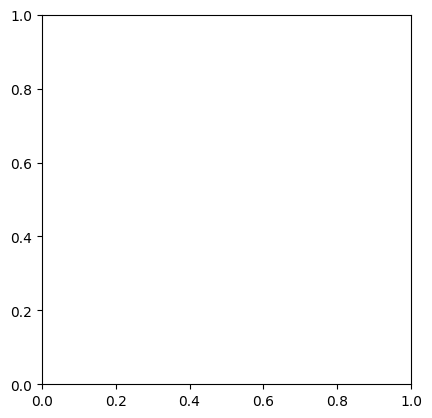

In [ ]:
def semcot_optimized(dsem_scores, isf_dict, epsilon_0=1.5, M=0.1, m=3, beta=0.9, mu=None):
    """
    Optimized Semantic Clustering of Terms (SEMCOT) algorithm with improved filtering and validation.
    """
    terms = list(isf_dict.keys())
    term_index = {term: idx for idx, term in enumerate(terms)}
    Nt = len(terms)

    # Create a sparse matrix for dissimilarity scores
    dsem_sparse = dok_matrix((Nt, Nt), dtype=np.float32)
    for (term_u, term_v), score in dsem_scores.items():
        i, j = term_index[term_u], term_index[term_v]
        dsem_sparse[i, j] = score
        dsem_sparse[j, i] = score  # Ensure symmetry


    # Convert sparse matrix to a dense one and fill missing values
    max_score = max(dsem_scores.values())
    dsem_sparse = dsem_sparse.toarray()
    dsem_sparse[dsem_sparse == 0] = max_score  # Replace missing entries with a large value

    # Initialize variables
    epsilon = epsilon_0
    max_cluster_size = int(M * Nt)
    proceed = True
    c = np.full(Nt, -1, dtype=int)
    K = 0

    while proceed:
        # Apply DBSCAN
        db = DBSCAN(eps=epsilon, min_samples=m, metric="precomputed")
        c_temp = db.fit_predict(dsem_sparse)

        # Filter out clusters with fewer than 2 elements
        cluster_sizes = {k: sum(c_temp == k) for k in set(c_temp) if k != -1}
        valid_clusters = {k for k, size in cluster_sizes.items() if size >= 2}

        # Update labels to exclude invalid clusters
        c_temp_filtered = np.array([label if label in valid_clusters else -1 for label in c_temp])

        # Check if clusters satisfy max cluster size constraint
        if max(cluster_sizes.values(), default=0) < max_cluster_size:
            proceed = False
            c = c_temp_filtered
        else:
            epsilon *= beta  # Decrease epsilon

    # Include noisy terms as single-term topics based on ISF threshold
    if mu is not None:
        for i, label in enumerate(c):
            if label == -1 and isf_dict[terms[i]] >= mu:
                c[i] = K
                K += 1

    # Calculate the final number of clusters
    K = len(set(c)) - (1 if -1 in c else 0)

    return K, c, epsilon

# Example ISF values
isf_dict = {
    'term1': 0.5, 'term2': 0.8, 'term3': 1.2, 'term4': 0.9, 'term5': 1.0
}

# Example dissimilarity scores
dsem_scores = {
    ('term1', 'term2'): 0.2, ('term1', 'term3'): 0.8,
    ('term2', 'term3'): 0.5, ('term2', 'term4'): 0.3,
    ('term3', 'term4'): 0.6, ('term4', 'term5'): 0.4
}

# Parameters
K, c, epsilon_final = semcot_optimized(
    dsem_scores, isf_dict, epsilon_0=1.5, M=0.2, m=2, beta=0.9, mu=0.7
)

# Results
print(f"Number of Topics: {K}")
print(f"Cluster Labels: {c}")
print(f"Final Epsilon: {epsilon_final}")

# Class

In [138]:
import numpy as np

class SentenceHypergraph:
    def __init__(self, sentences, themes, query, corpus):
        """
        Initialize the sentence hypergraph.

        Parameters:
        - sentences: List of sentences (nodes).
        - themes: Dictionary where keys are themes (hyperedges), and values are sets of sentence indices.
        - query: Query string for relevance calculation.
        - corpus: Entire corpus for centrality calculation.
        """
        self.sentences = sentences
        self.themes = themes
        self.query = query
        self.corpus = corpus

        # Node weights (sentence lengths)
        self.node_weights = np.array([len(sentence.split()) for sentence in sentences])

        # Hyperedges and their weights
        self.hyperedges = [set(sentences) for sentences in themes.values()]
        self.hyperedge_weights = self.compute_hyperedge_weights()

        # Incidence lists
        self.incidence_lists = self.compute_incidence_lists()

    def compute_hyperedge_weights(self, lambda_param=0.5):
        """
        Compute weights for hyperedges based on centrality and query relevance.

        Parameters:
        - lambda_param: Weighting parameter for centrality and query relevance.

        Returns:
        - List of hyperedge weights.
        """
        weights = []
        for theme_sentences in self.hyperedges:
            theme_text = " ".join([self.sentences[idx] for idx in theme_sentences])
            
            # Centrality: Similarity with the corpus
            centrality = self.compute_similarity(theme_text, self.corpus)
            
            # Relevance: Similarity with the query
            relevance = self.compute_similarity(theme_text, self.query)
            
            # Hyperedge weight
            weight = (1 - lambda_param) * centrality + lambda_param * relevance
            weights.append(weight)
        
        return np.array(weights)

    def compute_incidence_lists(self):
        """
        Compute incidence lists for nodes (sentences).

        Returns:
        - List of lists where each entry corresponds to the hyperedges incident on a node.
        """
        incidence = [[] for _ in range(len(self.sentences))]
        for e_idx, hyperedge in enumerate(self.hyperedges):
            for node in hyperedge:
                incidence[node].append(e_idx)
        return incidence

    def compute_similarity(self, text1, text2):
        """
        Compute cosine similarity between two texts based on TF-ISF.

        Parameters:
        - text1: First text.
        - text2: Second text.

        Returns:
        - Cosine similarity.
        """
        # Tokenize and compute term frequencies
        tf1 = self.compute_tf(text1)
        tf2 = self.compute_tf(text2)
        
        # Compute dot product and norms
        dot_product = sum(tf1[term] * tf2.get(term, 0) for term in tf1)
        norm1 = np.sqrt(sum(val ** 2 for val in tf1.values()))
        norm2 = np.sqrt(sum(val ** 2 for val in tf2.values()))

        return dot_product / (norm1 * norm2) if norm1 and norm2 else 0.0

    def compute_tf(self, text):
        """
        Compute term frequencies for a given text.

        Parameters:
        - text: Input text.

        Returns:
        - Dictionary of term frequencies.
        """
        words = text.split()
        tf = {}
        for word in words:
            tf[word] = tf.get(word, 0) + 1
        return tf


In [135]:
def tl_transum(hypergraph, target_length):
    """
    Transversal Summarization with Target Length (TL-TranSum).

    Parameters:
        hypergraph (SentenceHypergraph): The sentence hypergraph.
        target_length (int): Maximum length of the summary (in words).

    Returns:
        list: Indices of sentences to include in the summary.
    """
    # Initialize variables
    sentences = list(range(len(hypergraph.sentences)))
    node_weights = hypergraph.node_weights
    hyperedge_weights = hypergraph.hyperedge_weights
    incidence_lists = hypergraph.incidence_lists

    # Compute initial scores for each sentence
    scores = []
    for i in sentences:
        coverage = sum(hyperedge_weights[e] for e in incidence_lists[i])
        scores.append(coverage / node_weights[i])  # ri = 1/φi * ∑ w_e

    # Select sentences
    summary = set()
    total_length = 0

    while total_length < target_length:
        # Select the sentence with the highest score
        best_sentence = max(range(len(scores)), key=lambda i: scores[i])
        summary.add(best_sentence)

        # Update total length
        total_length += node_weights[best_sentence]

        # Update scores
        for i in sentences:
            if i not in summary:
                overlap = sum(hyperedge_weights[e] for e in incidence_lists[i] if e in incidence_lists[best_sentence])
                scores[i] -= overlap / node_weights[i]

        # Remove the selected sentence from the score computation
        scores[best_sentence] = -1

        # Break if all sentences are selected
        if total_length > target_length:
            break

    return list(summary)


In [145]:
query = "lazy"
corpus = " ".join(sentences)
target_length = 4

# Construct hypergraph
hypergraph = SentenceHypergraph(sentences, themes, query, corpus)

# Generate summary using TL-TranSum
summary_indices = tl_transum(hypergraph, target_length)

# Display the summary
summary = [sentences[i] for i in summary_indices]
print("Summary:", summary)


Summary: ['The five boxing wizards jump quickly.']


In [141]:
sentences

['The quick brown fox jumps over the lazy dog.',
 'A quick movement of the enemy will jeopardize six gunboats.',
 'The five boxing wizards jump quickly.']

In [137]:
themes

{0: {0, 1, 2}, 1: {0, 1, 2}, 2: {0, 1}, 3: {1, 2}}